In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6452, 24)
(6452, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24469903,  0.12789501, -0.38223135,  0.23550224,
       -0.12581065, -0.38087389, -0.25940979,  0.12626421, -0.39005604,
       -0.25385731, -0.13036206, -0.3819674 ,  0.0117262 ,  0.01019112,
        0.04017198, -0.08774932,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24469903,  0.12789501, -0.38223135,  0.23550224,
       -0.12581065, -0.38087389, -0.25940979,  0.12626421, -0.39005604,
       -0.25385731, -0.13036206, -0.3819674 ,  0.0117262 ,  0.01019112,
        0.04017198, -0.08774932,  0.        ,  1.        ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9882133974189198
RMSE:  0.013993048241212067
The lowest error is:  3.378938439047019e-07
The highest error is:  0.06017756085908785
The avg. error is:  0.010743377191537003


In [14]:
model_rl_relative_swinging_x.coef_

array([[ 1.94965408e-02,  3.33066907e-16, -5.55111512e-17,
         8.03194136e-02, -5.55111512e-17,  0.00000000e+00,
         4.99637754e-01, -2.53447057e-01,  5.69603407e-01,
        -9.90703045e-01, -1.01435870e-01, -8.33045096e-02,
        -8.28674516e-01, -1.80852269e-01, -1.54933834e+00,
        -6.65545577e-01]])

In [15]:
model_rl_relative_swinging_x.intercept_

array([-0.66872347])

Text(0, 0.5, 'Predictions')

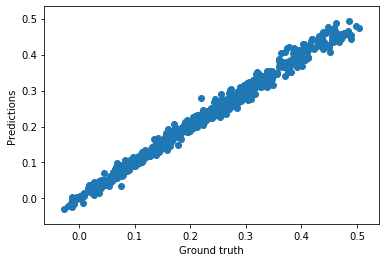

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [16]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.3270142962066349
RMSE:  0.006158816264655915
The lowest error is:  4.729670586289814e-06
The highest error is:  0.0268401589871598
The avg. error is:  0.004680921691859844


In [17]:
model_rl_relative_swinging_y.coef_

array([[-6.44554487e-03, -1.73472348e-16,  2.98372438e-16,
         2.37486144e-02,  2.22044605e-16,  0.00000000e+00,
        -8.30460916e-02,  5.66254760e-02, -1.51679171e-01,
         2.50757865e-01, -2.67388228e-01, -3.70967551e-01,
         6.30749988e-02, -8.10841086e-01,  4.34023112e-01,
         6.90536598e-01]])

In [18]:
model_rl_relative_swinging_y.intercept_

array([0.34199698])

Text(0, 0.5, 'Predictions')

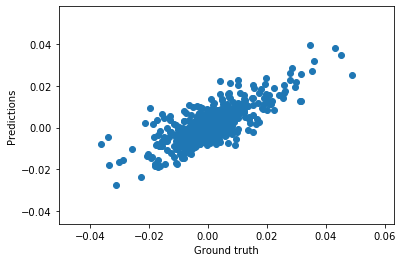

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')